## Case Study
This case study investigates which features we should use if we wanted to create a new candy. Therefore the goal is to find a combination which maximizes the total win percentage based on our dataset. 

## Imports

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import mplscience
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr, spearmanr
import statsmodels.api as sm
from relativeImp import relativeImp
from mlxtend.frequent_patterns import apriori
from sklearn.metrics import r2_score

## Function definitions
Define some functions which are useful to create significance brackets for Boxplots

In [3]:
def _add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot([left, left, right, right], [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs)

    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha="center",
        va="bottom",
        c="k",
    )
def _get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

## Data Reading

In [4]:
df = pd.read_csv("candy-data.csv")

## Check correlations

<Axes: >

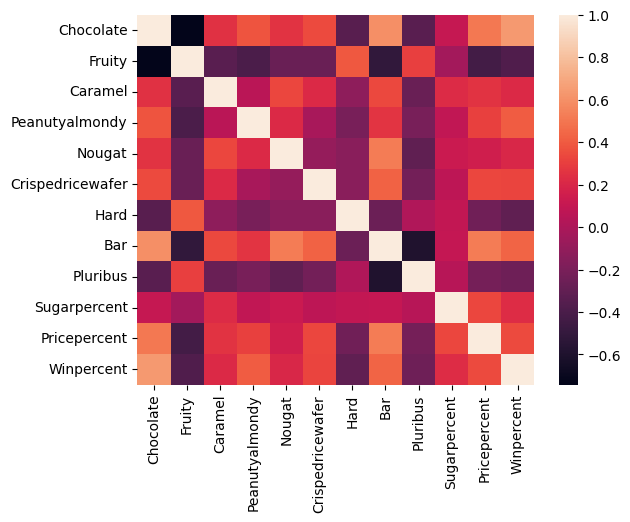

In [5]:
corr_ = df.rename(columns={col: col.capitalize() for col in df.columns}).corr(numeric_only=True)
sns.heatmap(corr_, )

## Investigate binary features

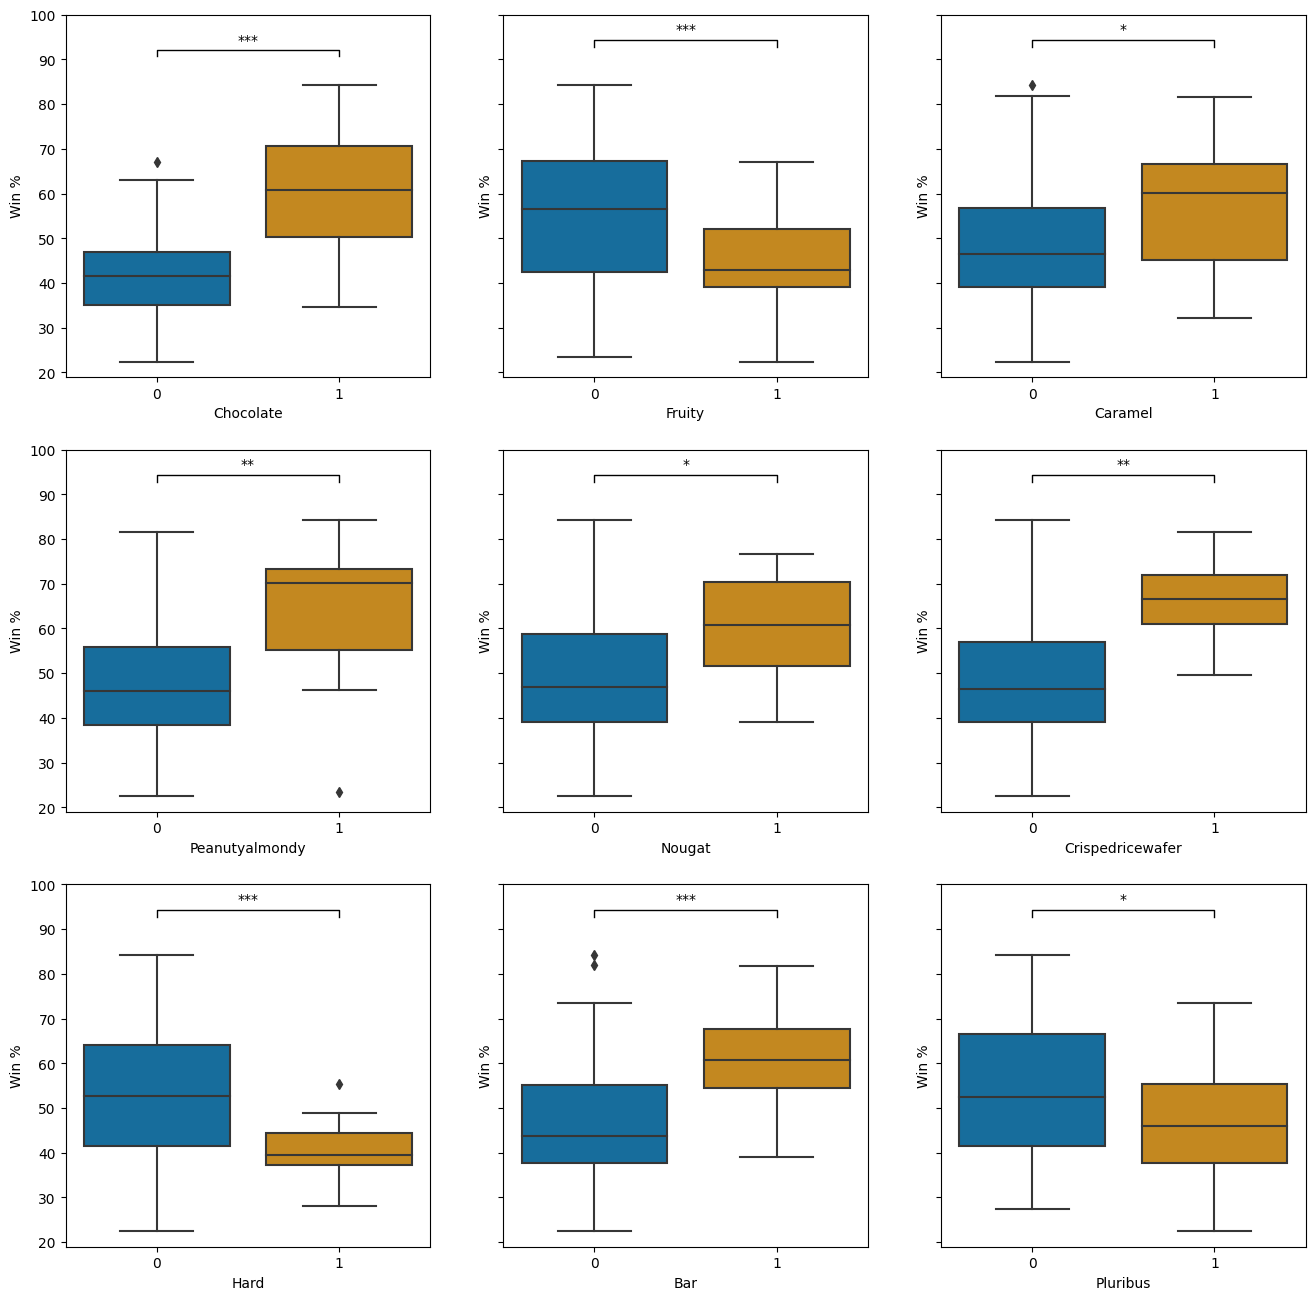

In [6]:
one_hot_features = ['chocolate', 'fruity', 'caramel', 'peanutyalmondy',
                    'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']

palette = dict(zip([0,1], sns.color_palette("colorblind").as_hex()[:2]))


fig, axs = plt.subplots(nrows=3,ncols=3, sharey=True, sharex=False, figsize=(16,16))
for feat, ax in zip(one_hot_features, axs.reshape(-1)): 
    sns.boxplot(x=feat, y="winpercent", data=df, palette=palette, ax=ax)
    ax.set_xlabel(feat.capitalize())
    ax.set_ylabel("Win %")

    # T-test of the feature
    ttest_res = ttest_ind(
        df.loc[df[feat] == 0, "winpercent"],
        df.loc[df[feat] == 1, "winpercent"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    if feat!= "chocolate":
        _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1,
        c="k",
        level=-1,
        )
    else:
        _add_significance(
            ax=ax,
            left=0,
            right=1,
            significance=significance,
            lw=1,
            bracket_level=1,
            c="k",
            level=1,
        )
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, 100])

plt.show()

Create single `.svg` for each plot

In [39]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    for feat in one_hot_features: 
        fig, ax = plt.subplots()
        sns.boxplot(x=feat, y="winpercent", data=df, palette=palette, ax=ax)
        ax.set_xlabel(feat.capitalize())
        ax.set_ylabel("Win %")

        # T-test of the feature
        ttest_res = ttest_ind(
            df.loc[df[feat] == 0, "winpercent"],
            df.loc[df[feat] == 1, "winpercent"],
            equal_var=False,
            alternative="two-sided",
        )
        significance = _get_significance(ttest_res.pvalue)
        _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1,
        c="k",
        level=1,
        )

        y_min, y_max = ax.get_ylim()
        ax.set_ylim([20, 100])
        fig.savefig(f"plots/{feat}_boxplot.svg", format="svg", transparent=True, bbox_inches="tight")
        plt.close(fig)

## Investigate numeric features
Run Linear Regression Models with single numeric features and investigate correlations
- winpercent = $\beta$ * sugarpercent + $\epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2)$
- winpercent = $\beta$ * pricepercent + $\epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2)$

PearsonRResult(statistic=0.2291506571280065, pvalue=0.03489789676169812)
SpearmanrResult(correlation=0.21793714494295427, pvalue=0.04510378936481295)


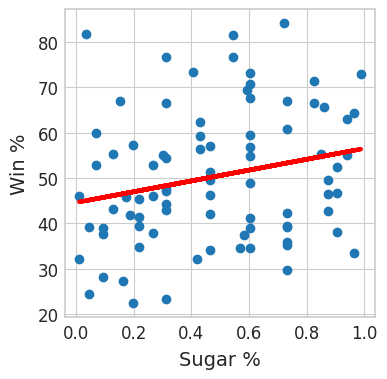

In [42]:
X = df["sugarpercent"].to_numpy().reshape(-1,1)
reg = LinearRegression().fit(X, df["winpercent"])
reg.score(X, df["winpercent"])

y_pred = reg.predict(X)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots()
    ax.scatter(X, df["winpercent"], )
    ax.plot(X, y_pred, color="red", linewidth=3)
    ax.set_xlabel("Sugar %")
    ax.set_ylabel("Win %")
    fig.savefig(f"plots/sugarpercent_regression.svg", format="svg", transparent=True, bbox_inches="tight")

print(pearsonr(X.reshape(-1), df["winpercent"]))
print(spearmanr(X.reshape(-1), df["winpercent"]))


PearsonRResult(statistic=0.34532540996768485, pvalue=0.0012088290261781025)
SpearmanrResult(correlation=0.35274923504075195, pvalue=0.0009291200306824364)


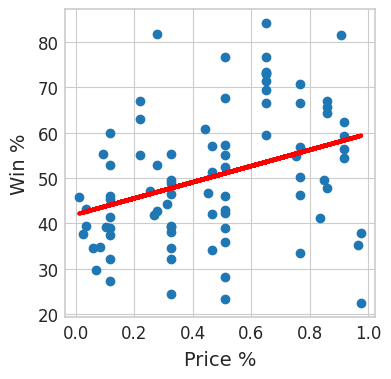

In [43]:
X = df["pricepercent"].to_numpy().reshape(-1,1)

reg = LinearRegression().fit(X, df["winpercent"])
reg.score(X, df["winpercent"])

y_pred = reg.predict(X)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots()
    ax.scatter(X, df["winpercent"])
    ax.plot(X, y_pred, color="red", linewidth=3)
    ax.set_xlabel("Price %")
    ax.set_ylabel("Win %")
    fig.savefig(f"plots/pricepercent_regression.svg", format="svg", transparent=True, bbox_inches="tight")

print(pearsonr(X.reshape(-1), df["winpercent"]))
print(spearmanr(X.reshape(-1), df["winpercent"]))


## Linear Regression with all features
$y = \beta X + \epsilon$ 

Here, we model $y=$`winpercent` by all features and Datapoints $X$. Let $N \in \mathbb{N}$ denote the number of used features. Note that $\beta \in \mathbb{R}^{N+1}$ which includes the interception coefficient $\beta_0$. Further let $\epsilon \sim \mathcal{N}(0,\sigma^2)$ denote the noise.

In [44]:
features = ['chocolate', 'fruity', 'caramel', 'peanutyalmondy',
            'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
            'pricepercent']
X = df[features].to_numpy()

est = LinearRegression()

reg = est.fit(X, df["winpercent"])
reg.score(X, df["winpercent"])
y_pred = reg.predict(X)
df["predicted_winpercent"] = y_pred

## Plot the fitted coefficients
The sign of a linear regression coefficient tells us whether there is a positive or negative correlation between each independent variable and the dependent variable. A positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase. A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease.

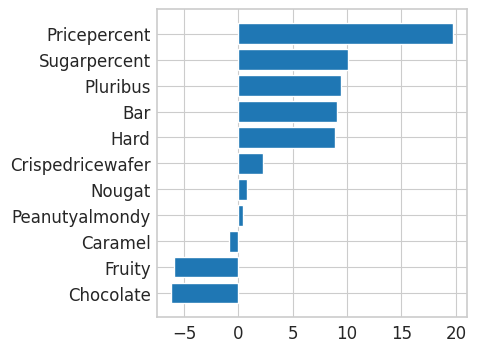

In [46]:
features_sorted = [features[feat] for feat in np.argsort(reg.coef_).tolist()]
reg.coef_.sort()

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots()
    ax.barh([f.capitalize() for f in features_sorted], reg.coef_)
    fig.savefig(f"plots/linear_coefficients.svg", format="svg", transparent=True, bbox_inches="tight")


## For nice summary use sm
Here we aim to get $P$-values to investigate wether a feature is relevant, i.e. $H_0$ hypothesis: The featuere $i$ has no correlation with the dependent variable (and therefore for the linear regression coefficient $\beta_i=0$). We use $\alpha=0.05$ as significance level and reject $H_0$ if $P<\alpha$.

We observe that we reject the $H_0$ for `[chocolate, peanutyalmondy, fruity]`. For all other features we fail to reject $H_0$. 

In [11]:
X2 = sm.add_constant(X, prepend=False)
est = sm.OLS(df["winpercent"], X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:             winpercent   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     7.797
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           9.50e-09
Time:                        15:08:26   Log-Likelihood:                -315.64
No. Observations:                  85   AIC:                             655.3
Df Residuals:                      73   BIC:                             684.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            19.7481      3.899      5.065      0.0

In [15]:
r2_score(df["winpercent"], df["predicted_winpercent"])
# r-squared of 0.5402 which implies that 54.02% of the variance of winpercent can be explained by the factors we have used. 

0.5402088191987462

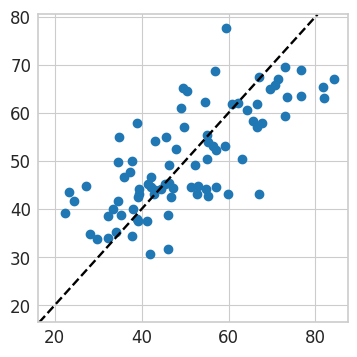

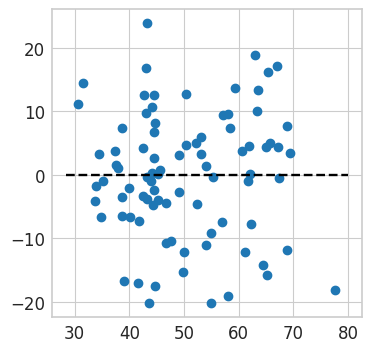

In [48]:
# https://statisticsbyjim.com/regression/check-residual-plots-regression-analysis/
# https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/
# check if we have unbiased estimator
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots()
    ax.scatter(df["winpercent"], df["predicted_winpercent"])
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    ax.axline((x_lim[0], x_lim[0]), slope=1, color="black", linestyle="--")
    fig.savefig(f"plots/y_true_vs_y_pred.svg", format="svg", transparent=True, bbox_inches="tight")


# also run residual plot
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots()
    ax.scatter(df["predicted_winpercent"], df["winpercent"] - df["predicted_winpercent"])
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    ax.hlines(y=0, xmin=x_lim[0], xmax=x_lim[1], color="black", linestyle="--")
    fig.savefig(f"plots/residual.svg", format="svg", transparent=True, bbox_inches="tight")

## Key driver analysis to quantify the relative importance of individual features
 `df_results.normRelaImpt` sums up to $100$
 
 `df_results.rawRelaImpt` sums up to $R^2$


Partition explained variance among multiple predictors to better understand the role played by each predictor/ feature.
Eventhough, fruity has high coefficient, we might not choose it to be a feature of our candy.

$R^2$ describes how much variance is explained by our features or predicted by the features. In Key Driver Analysis the higher the importance value, the more a potential driver affects the outcome metric/ the winpercent.

We therefore would recomment to use [`chocolate`, `peanutyalmondy`, `crispedricewafer`, `none hard`] if we would like to create a new candy.

In [62]:
df_results = relativeImp(df, outcomeName = "winpercent", driverNames = features)
df_results = df_results.sort_values(by="rawRelaImpt", ascending=False)
df_results

,driver,rawRelaImpt,normRelaImpt
0,chocolate,0.202000,37.392922
3,peanutyalmondy,0.082663,15.302103
5,crispedricewafer,0.046034,8.521568
6,hard,0.041736,7.725844
1,fruity,0.039526,7.316789
7,bar,0.039501,7.312241
9,sugarpercent,0.034004,6.294570
10,pricepercent,0.020713,3.834274
8,pluribus,0.015195,2.812766
2,caramel,0.009710,1.797506


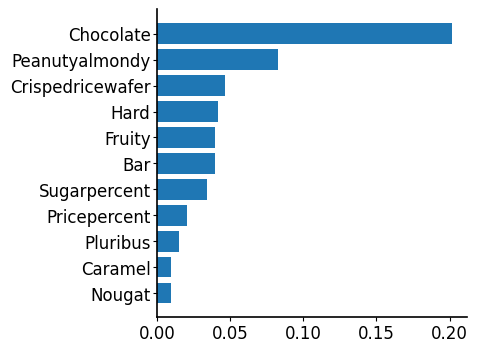

In [66]:
with mplscience.style_context():
    fig, ax = plt.subplots()
    df_results["driver"] = df_results["driver"].str.capitalize()
    ax.barh(df_results["driver"], df_results["rawRelaImpt"])
    ax.invert_yaxis()
    fig.savefig(f"plots/key_drivers.svg", format="svg", transparent=True, bbox_inches="tight")


## Check if number of features has impact on win
Finally, we check if candies with multiple features, i.e. candies declared as ``chocolate`` and ``peanutyalmondy`` have higher winpercent.

We observe a trend and positive correlation which however due to the little data points available only gives an indication.

PearsonRResult(statistic=0.46775327353561164, pvalue=6.370846832869972e-06)
SpearmanrResult(correlation=0.4797558016396636, pvalue=3.3873842695717303e-06)


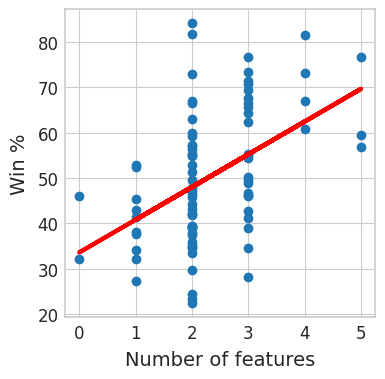

In [55]:
df["number_features"] = df[one_hot_features].sum(axis=1)

X = df["number_features"].to_numpy().reshape(-1,1)

reg = LinearRegression().fit(X, df["winpercent"])
reg.score(X, df["winpercent"])

y_pred = reg.predict(X)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots()
    ax.scatter(X, df["winpercent"])
    ax.plot(X, y_pred, color="red", linewidth=3)
    ax.set_xlabel("Number of features")
    ax.set_ylabel("Win %")
    fig.savefig(f"plots/number_features.svg", format="svg", transparent=True, bbox_inches="tight")


print(pearsonr(X.reshape(-1), df["winpercent"]))
print(spearmanr(X.reshape(-1), df["winpercent"]))


I would also like to check which combinations are the most common ones to get a better understanding of different candies

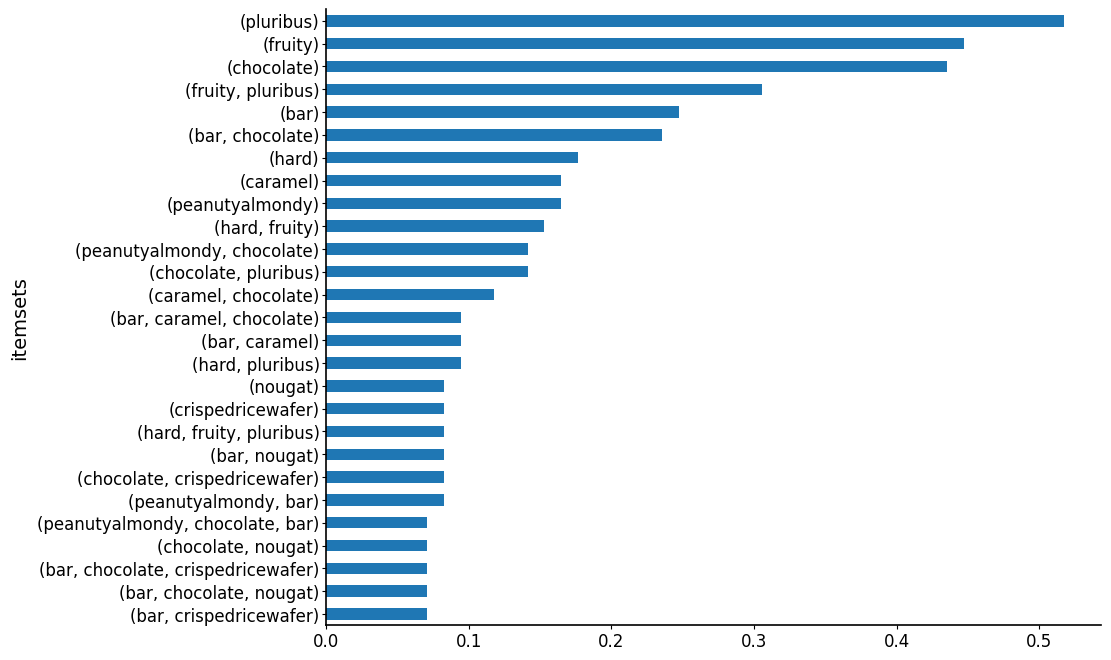

In [58]:
df_ =  df[one_hot_features].astype(bool)
association = apriori(df_, min_support=0.05,use_colnames=True).sort_values(by='support')

with mplscience.style_context():
    # sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 8))
    association.plot(kind='barh',x='itemsets',y='support',legend=False, ax=ax)
    fig.savefig(f"plots/feaature_combination.svg", format="svg", transparent=True, bbox_inches="tight")

## Deep Dive Fruity

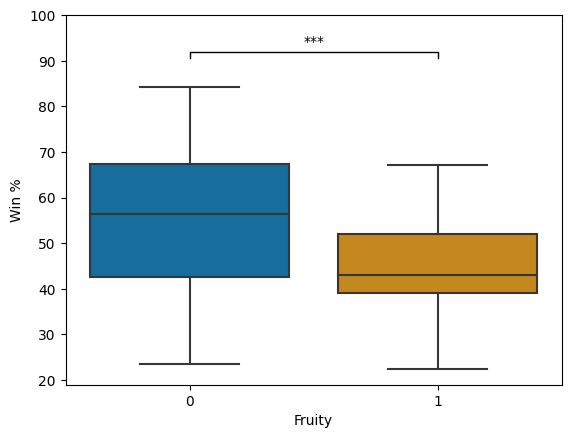

In [308]:
fig, ax = plt.subplots()
feat = "fruity"
sns.boxplot(x=feat, y="winpercent", data=df, palette=palette, ax=ax)
ax.set_xlabel(feat.capitalize())
ax.set_ylabel("Win %")

# T-test of the feature
ttest_res = ttest_ind(
    df.loc[df[feat] == 0, "winpercent"],
    df.loc[df[feat] == 1, "winpercent"],
    equal_var=False,
    alternative="two-sided",
)
significance = _get_significance(ttest_res.pvalue)
_add_significance(
ax=ax,
left=0,
right=1,
significance=significance,
lw=1,
bracket_level=1,
c="k",
level=1,
)
y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, 100])


plt.show()

Now look at candies which only have one feature and compare candies which are only fruity to the remaining candies which do not contain fruity flavor

(18.96657662385, 97.49939289915)

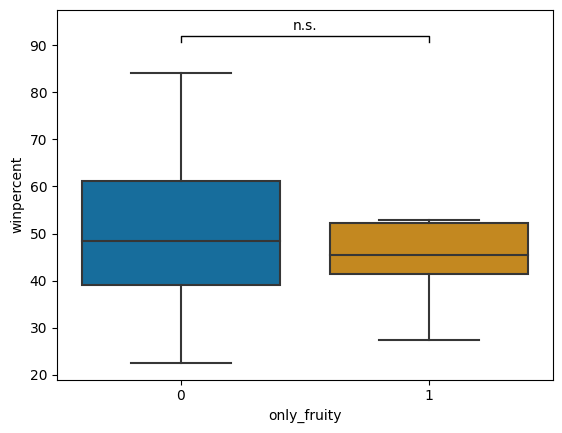

In [309]:
df["only_fruity"] = np.where((df.fruity==1) & (df.number_features==1), 1, 0)

fig, ax = plt.subplots()
feat = "only_fruity"
sns.boxplot(x=feat, y="winpercent", data=df, palette=palette, ax=ax)

# T-test of the feature
ttest_res = ttest_ind(
    df.loc[(df[feat] == 0) , "winpercent"],
    df.loc[(df[feat] == 1) & (df.number_features==1), "winpercent"],
    equal_var=False,
    alternative="two-sided",
)
significance = _get_significance(ttest_res.pvalue)
_add_significance(
ax=ax,
left=0,
right=1,
significance=significance,
lw=1,
bracket_level=1,
c="k",
level=1,
)
y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max+2])

(25.860880853549997, 59.60653207545)

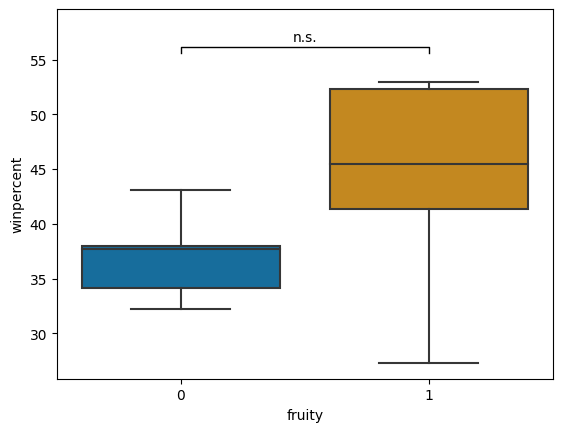

In [310]:
fig, ax = plt.subplots()
feat = "fruity"
sns.boxplot(x=feat, y="winpercent", data=df[df.number_features==1], palette=palette, ax=ax)

# T-test of the feature
ttest_res = ttest_ind(
    df.loc[(df[feat] == 0) & (df.number_features==1) , "winpercent"],
    df.loc[(df[feat] == 1) & (df.number_features==1), "winpercent"],
    equal_var=False,
    alternative="two-sided",
)
significance = _get_significance(ttest_res.pvalue)
_add_significance(
ax=ax,
left=0,
right=1,
significance=significance,
lw=1,
bracket_level=1,
c="k",
level=1,
)
y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max+2])

## Print all used libraries and add them to `requirements.txt`

In [67]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


pandas==1.5.3
numpy==1.23.5
seaborn==0.12.2
statsmodels.api==0.14.0
mplscience==0.0.7
